# Experiments Second Sample

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [49]:
% matplotlib inline

import os
import sys
import tempfile

sys.path.append("..")

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import fourier_help

import pytff

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

pd.options.mode.chained_assignment = None 

## 1. Load Data

In [57]:
path = "/home/data/carpyncho/stored/samples/b278_sample.npy"
df = pd.DataFrame(np.load(path))

##  2. Preprocess

### 2.1. Discretize the classes

In [58]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

In [59]:
ros = RandomOverSampler()
smote = SMOTE()
adasyn = ADASYN()

In [60]:
# RR lyrae
df = df[df.scls.isin([3, 0])]

# columns with nan and null
df = df.loc[:, ~df.isnull().any()]

X_columns = df.columns[~df.columns.isin(["id", "cls", "scls", "ogle3_type"])]
X_columns = X_columns[~X_columns.str.startswith("Signature_")]
y = df["scls"].values

# low variance
vt = fs.VarianceThreshold()
vt.fit(df[X_columns].values, y)

print "total features:", len(X_columns)

total features: 57


In [61]:
X_columns = X_columns[vt.get_support()]
X_scaled = prp.StandardScaler().fit_transform(df[X_columns].values)

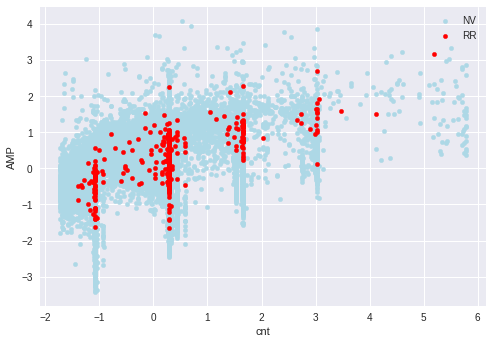

In [63]:
tpdf = pd.DataFrame(X_scaled, columns=X_columns)
tpdf["scls"] = pd.Series(y, index=tpdf.index)
ax = tpdf[tpdf.scls == 0].plot.scatter(x=X_columns[0], y=X_columns[1], color='LightBlue', label='NV')
tpdf[tpdf.scls == 3].plot.scatter(x=X_columns[0], y=X_columns[1], color='Red', label='RR', ax=ax)

[(0, 20000), (3, 20000)]


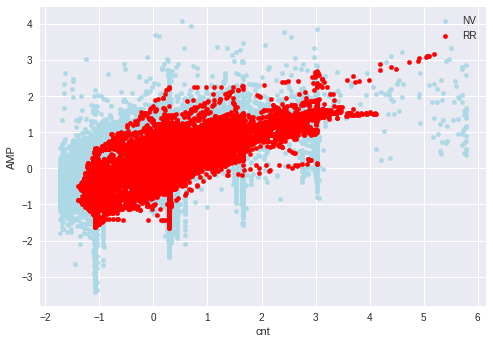

In [64]:
X_resampled, y_resampled = smote.fit_sample(X_scaled, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

tpdf = pd.DataFrame(X_resampled, columns=X_columns)
tpdf["scls"] = pd.Series(y_resampled, index=tpdf.index)
ax = tpdf[tpdf.scls == 0].plot.scatter(x=X_columns[0], y=X_columns[1], color='LightBlue', label='NV')
tpdf[tpdf.scls == 3].plot.scatter(x=X_columns[0], y=X_columns[1], color='Red', label='RR', ax=ax);

[(0, 20000), (3, 19921)]


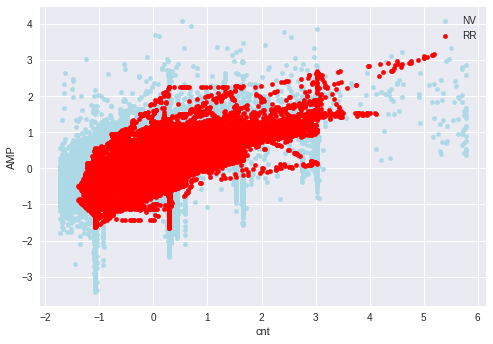

In [67]:
X_resampled, y_resampled = adasyn.fit_sample(X_scaled, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

tpdf = pd.DataFrame(X_resampled, columns=X_columns)
tpdf["scls"] = pd.Series(y_resampled, index=tpdf.index)
ax = tpdf[tpdf.scls == 0].plot.scatter(x=X_columns[0], y=X_columns[1], color='LightBlue', label='NV')
tpdf[tpdf.scls == 3].plot.scatter(x=X_columns[0], y=X_columns[1], color='Red', label='RR', ax=ax);

[(0, 20000), (3, 20000)]


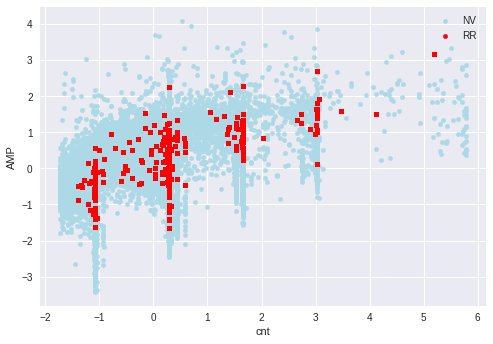

In [68]:
X_resampled, y_resampled = ros.fit_sample(X_scaled, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

tpdf = pd.DataFrame(X_resampled, columns=X_columns)
tpdf["scls"] = pd.Series(y_resampled, index=tpdf.index)
ax = tpdf[tpdf.scls == 0].plot.scatter(x=X_columns[0], y=X_columns[1], color='LightBlue', label='NV')
tpdf[tpdf.scls == 3].plot.scatter(x=X_columns[0], y=X_columns[1], color='Red', label='RR', ax=ax);